Group Members: Renjie Dai (ID: 1007547219), Wenxin Li (ID: 1007508724)

In [1]:
# APS1052 Final Project: Recommendation System by NMF
#
# Renjie Dai <renjie.dai@mail.utoronto.ca>
# Wenxin Li <wency.li@mail.utoronto.ca>
#
#This notebook aims to build a recommendation system based on NMF by using 
#surprise lib(http://surpriselib.com/). The data is from WRDS, and it is 
#captured by kernel579f01f557_DFData.ipynb.


In [2]:
'''Main'''
import pandas as pd
import numpy as np

'''Data Viz'''
import matplotlib.pyplot as plt

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as skl_train_test_split
from sklearn.metrics import mean_squared_error

'''Surprise Lib'''
from surprise import SVD,NMF, BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split as sur_train_test_split
from surprise import accuracy

In [3]:
#Load the data
df = pd.read_csv('DF3.csv')

In [4]:
df.head()

,Unnamed: 0,mgrno,permno,por_per_stock,rdate,qdate
0,0,110.0,66093.0,0.001939,2018-03-31,2018-03-31
1,1,110.0,20482.0,0.000260,2018-03-31,2018-03-31
2,2,110.0,13721.0,0.000575,2018-03-31,2018-03-31
3,3,110.0,71271.0,0.000488,2018-03-31,2018-03-31
4,4,110.0,14542.0,0.000411,2018-03-31,2018-03-31


In [5]:
df.shape

(10670491, 6)

In [6]:
#Drop useless colunms
df.drop(['Unnamed: 0','rdate'], axis=1, inplace=True)
#Replace nans to 0
df['por_per_stock'] = df['por_per_stock'].replace(np.nan, 0)
#Vary the scale if needed
scaler = MinMaxScaler(feature_range=(0,1))
#df[["por_per_stock"]] = scaler.fit_transform(df[["por_per_stock"]])

In [7]:
# Convert fields into appropriate data types
df.mgrno = df.mgrno.astype(int)
df.permno = df.permno.astype(int)
df.por_per_stock = df.por_per_stock.astype(float)
df.qdate = pd.to_datetime(df.qdate)

In [8]:
df.head()

,mgrno,permno,por_per_stock,qdate
0,110,66093,0.001939,2018-03-31
1,110,20482,0.000260,2018-03-31
2,110,13721,0.000575,2018-03-31
3,110,71271,0.000488,2018-03-31
4,110,14542,0.000411,2018-03-31


In [9]:
#Pick the most recent managers' rating
df.sort_values(by=['qdate'],ascending=False,inplace=True)
df = df.groupby(['mgrno','permno']).head(1)
df.drop("qdate", axis=1, inplace=True)

In [10]:
# Calculate summary statistics on full dataset

# 2,261,139 ratings
# 26,744 unique movies
# 138,493 unique users
# 144 ratings on average per user

n_mgrs = df.mgrno.unique().shape[0]
n_permon = df.permno.unique().shape[0]
n_ratings = len(df)
avg_ratings_per_mgr = n_ratings/n_mgrs

print('Number of unique managers: ', n_mgrs)
print('Number of unique stocks: ', n_permon)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per manager: ', avg_ratings_per_mgr)

Number of unique managers:  6038
Number of unique stocks:  8466
Number of total ratings:  2261139
Average number of ratings per manager:  374.48476316661146


In [11]:
# Preview data
df.head()

,mgrno,permno,por_per_stock
5335245,12902,71271,0.000013
4465954,12116,84398,0.029516
4465948,12116,86996,0.000006
4465949,12116,68196,0.000002
4465950,12116,54199,0.000002


In [12]:
# Reduce size of dataset by select the number of stocks
stockIndex = df.groupby("permno").count().sort_values(by= \
                "por_per_stock",ascending=False).iloc[0:1500].index
dfx2 = df[df.permno.isin(stockIndex)]
dfx2.count()

mgrno            1366712
permno           1366712
por_per_stock    1366712
dtype: int64

In [13]:
# Reduce size of dataset by sampling the number of managers
mgrIndex = dfx2.groupby("mgrno").count().sort_values(by= \
    "por_per_stock",ascending=False).sample(n=4200, random_state=2018).index
dfx3 = dfx2[dfx2.mgrno.isin(mgrIndex)]
dfx3.count()

mgrno            993411
permno           993411
por_per_stock    993411
dtype: int64

In [14]:
# Calculate summary statistics on reduced dataset
n_mgrs = dfx3.mgrno.unique().shape[0]
n_permon = dfx3.permno.unique().shape[0]
n_ratings = len(dfx3)
avg_ratings_per_mgr = n_ratings/n_mgrs

print('Number of unique managers: ', n_mgrs)
print('Number of unique stocks: ', n_permon)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per manager: ', avg_ratings_per_mgr)

Number of unique managers:  4200
Number of unique stocks:  1500
Number of total ratings:  993411
Average number of ratings per manager:  236.52642857142857


In [15]:
#Split Data by Sklearn
#(Since the trainset from surprise spliter is unreadable, estimate sparsity by sklearn spliter with the same random state.)
traindata, testset = skl_train_test_split(dfx3, test_size=0.1,random_state=42)
validation, testset = skl_train_test_split(testset, test_size=0.50, shuffle=True, random_state=42)

In [16]:
print('Size of train set: ', len(traindata))
print('Size of validation set: ', len(validation))
print('Size of test set: ', len(testset))

Size of train set:  894069
Size of validation set:  49671
Size of test set:  49671


In [17]:
# Generate ratings matrix for train
ratings_train = traindata.pivot_table(index = 'mgrno', columns ='permno', values = 'por_per_stock').fillna(0)
sparsity = len(ratings_train.to_numpy().nonzero()[0])/(ratings_train.shape[0] * ratings_train.shape[1])*100
print('Trainset Sparsity: {:4.2f}%'.format(sparsity))

Trainset Sparsity: 14.24%


In [18]:
# Generate ratings matrix for validation
ratings_validation = validation.pivot_table(index = 'mgrno', columns ='permno', values = 'por_per_stock').fillna(0).values

In [19]:
# Generate ratings matrix for test
ratings_test = pd.DataFrame(testset,columns=['mgrno', 'permno', 'por_per_stock']).pivot_table(index = 'mgrno', columns ='permno', values = 'por_per_stock').fillna(0)
sparsity = len(ratings_test.to_numpy().nonzero()[0])/(ratings_test.shape[0] * ratings_test.shape[1])*100
print('Testset Sparsity: {:4.2f}%'.format(sparsity))

Testset Sparsity: 0.92%


# Experiment One: 

Predict a user's rating based on user's average rating for all other movies

In [20]:
#The same thing in In 10_rbms_mod - for_students_freeze2.ipynb

default = dfx3.por_per_stock.median()
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()
pred_validation = np.zeros((actual_validation.shape[0],1))
pred_validation[pred_validation==0] = default
naive_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using naive prediction:', naive_prediction)

Mean squared error using naive prediction: 5.104409698130562e-05


In [21]:
ratings_validation_prediction = np.zeros((n_mgrs, n_permon))
i = 0
for row in ratings_train:
    try:
        ratings_validation_prediction[i][ratings_validation_prediction[i]==0] \
            = np.mean(row[row>0])
        i += 1
    except:
        ratings_validation_prediction[i][ratings_validation_prediction[i]==0] \
        = default
        i += 1
        

pred_validation = ratings_validation_prediction \
    [ratings_validation.nonzero()].flatten()
#user_average = mean_squared_error(pred_validation, actual_validation)
#print('Mean squared error using user average:', user_average)

In [22]:
print(pred_validation.shape)
print(actual_validation.shape)
print(type(pred_validation))
print(type(actual_validation))
pred_validation = np.nan_to_num(pred_validation, nan=default, posinf=default, neginf=default) #errors 
actual_validation = np.nan_to_num(actual_validation, nan=default, posinf=default, neginf=default) #errors

(49671,)
(49671,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [23]:
user_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using user average:', user_average)

Mean squared error using user average: 5.110372573290788e-05


# Experiment Two:
Recommender System using Matrix Factorization (NMF)\
MSE vs Latent factors

In [24]:
#Split Data by Surprise
reader = Reader(rating_scale=(0, 1))
dfsu = Dataset.load_from_df(dfx3,reader)
trainset, testset = sur_train_test_split(dfsu, test_size=0.1,random_state=42)

In [25]:
def mse_vs_factors(factor_range, trainset, testset, epochs):
    """Returns: 
    factor_range for loop start at 1
    trainset & testset from surprise spliter
    epochs for NMF epochs, default is 50
    """

    mse_list = []
    latent_factor_num = []

    for k in factor_range:
        algo = NMF(n_factors = k, n_epochs = epochs)
        algo.fit(trainset)
        predictions = algo.test(testset)
        print('Latent Factor =' ,k) ,mse_list.append(accuracy.mse(predictions,verbose=False))
        print('MSE:',mse_list[-1])
        latent_factor_num.append(k)
    plt.subplot()
    plt.title("MSE Against Number of Factors", size = 15 , y=1.08)
    plt.plot(latent_factor_num, mse_list)
    plt.xlabel("Number of Latent Factor")
    plt.ylabel("MSE")
    return mse_list, latent_factor_num

Latent Factor = 1
MSE: 4.7459256161385175e-05
Latent Factor = 2
MSE: 4.7459256161377226e-05
Latent Factor = 3
MSE: 4.7459256160930894e-05
Latent Factor = 4
MSE: 4.745925616408226e-05
Latent Factor = 5
MSE: 4.7459256168279955e-05
Latent Factor = 6
MSE: 4.7459256167132375e-05
Latent Factor = 7
MSE: 4.745925617033228e-05
Latent Factor = 8
MSE: 4.745925616733986e-05
Latent Factor = 9
MSE: 4.745925617003412e-05


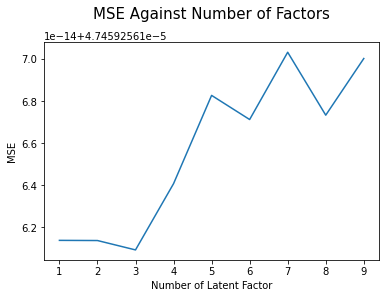

In [26]:
#Vary number of latent factors with factor_range
factor_range = range(1,10)
result = mse_vs_factors(factor_range, trainset, testset, 50)

# Experiment 3: Vary the Sparsity

In [27]:
# Reduce size of dataset by taking top 3000 stocks
stockIndex = df.groupby("permno").count().sort_values(by= \
                "por_per_stock",ascending=False).iloc[0:3000].index
dfx2_s = df[df.permno.isin(stockIndex)]

# Reduce size of dataset by sampling the number of managers
mgrIndex = dfx2_s.groupby("mgrno").count().sort_values(by= \
    "por_per_stock",ascending=False).sample(n=3500, random_state=2018).index
dfx3_s = dfx2_s[dfx2_s.mgrno.isin(mgrIndex)]
# Calculate summary statistics and sparsity
n_mgrs = dfx3_s.mgrno.unique().shape[0]
n_permon = dfx3_s.permno.unique().shape[0]
n_ratings = len(dfx3_s)
avg_ratings_per_mgr = n_ratings/n_mgrs
traindata_s, testset_s = skl_train_test_split(dfx3_s, test_size=0.1,random_state=42)
# Generate ratings matrix for train
ratingtrain = traindata_s.pivot_table(index = 'mgrno', columns ='permno', values = 'por_per_stock').fillna(0)
sparsity = len(ratingtrain.to_numpy().nonzero()[0])/(ratingtrain.shape[0] * ratingtrain.shape[1])*100

print('Number of unique managers: ', n_mgrs)
print('Number of unique stocks: ', n_permon)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per manager: ', avg_ratings_per_mgr)
print('Trainset Sparsity: {:4.2f}%'.format(sparsity))

Number of unique managers:  3500
Number of unique stocks:  3000
Number of total ratings:  1083502
Average number of ratings per manager:  309.572
Trainset Sparsity: 9.30%


In [28]:
dfsu_s = Dataset.load_from_df(dfx3_s,reader)
trainset_s, testset_s = sur_train_test_split(dfsu_s, test_size=0.1,random_state=42)

Latent Factor = 1
MSE: 3.404285323855071e-05
Latent Factor = 2
MSE: 3.404286188340639e-05
Latent Factor = 3
MSE: 3.404287515420364e-05
Latent Factor = 4
MSE: 3.404285755697598e-05
Latent Factor = 5
MSE: 3.404286356024768e-05
Latent Factor = 6
MSE: 3.4042863552202474e-05
Latent Factor = 7
MSE: 3.404287007742251e-05
Latent Factor = 8
MSE: 3.40428717030882e-05
Latent Factor = 9
MSE: 3.404286057537597e-05


([3.404285323855071e-05,
  3.404286188340639e-05,
  3.404287515420364e-05,
  3.404285755697598e-05,
  3.404286356024768e-05,
  3.4042863552202474e-05,
  3.404287007742251e-05,
  3.40428717030882e-05,
  3.404286057537597e-05],
 [1, 2, 3, 4, 5, 6, 7, 8, 9])

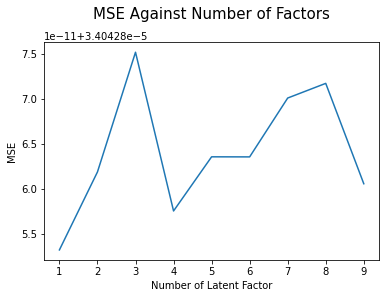

In [29]:
mse_vs_factors(factor_range, trainset_s, testset_s, 50)

# Experiment 4: Cut the tail

In [30]:
df.describe()

,mgrno,permno,por_per_stock
count,2.261139e+06,2.261139e+06,2.261139e+06
mean,2.486851e+04,5.419670e+04,6.385622e-04
std,2.193534e+04,3.333099e+04,6.240875e-03
min,1.100000e+02,1.002600e+04,0.000000e+00
25%,1.128000e+04,1.643100e+04,2.915520e-06
50%,1.401000e+04,6.474200e+04,2.758138e-05
75%,2.792600e+04,8.815900e+04,1.975777e-04
max,9.510500e+04,9.343600e+04,1.000000e+00


<AxesSubplot:ylabel='Frequency'>

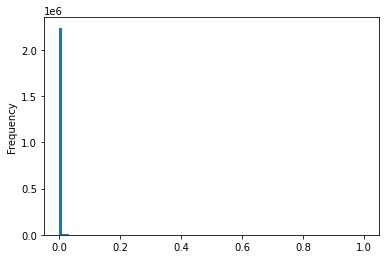

In [31]:
df.por_per_stock.plot.hist(bins=100)

In [32]:
dfc = df[df.por_per_stock < 0.0006]
dfc.describe()

,mgrno,permno,por_per_stock
count,1.948288e+06,1.948288e+06,1.948288e+06
mean,2.535802e+04,5.426651e+04,7.372495e-05
std,2.249670e+04,3.332580e+04,1.225510e-04
min,1.100000e+02,1.002600e+04,0.000000e+00
25%,1.122200e+04,1.643100e+04,1.975159e-06
50%,1.398000e+04,6.499500e+04,1.580298e-05
75%,2.807000e+04,8.784200e+04,8.442267e-05
max,9.510500e+04,9.343600e+04,5.999981e-04


<AxesSubplot:ylabel='Frequency'>

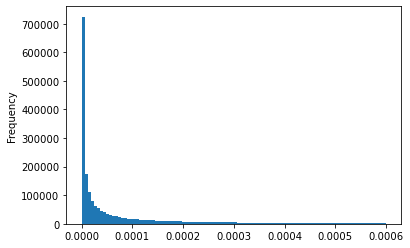

In [33]:
dfc.por_per_stock.plot.hist(bins=100)

In [34]:
#Vary the scale if needed
scaler = MinMaxScaler(feature_range=(0,1))
dfc.iloc[:,2:] = scaler.fit_transform(dfc.iloc[:,2:])
dfc.head()

C:\Users\ASUS\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,mgrno,permno,por_per_stock
5335245,12902,71271,0.022258
4465948,12116,86996,0.009636
4465949,12116,68196,0.003471
4465950,12116,54199,0.002859
4465951,12116,66325,0.006919


In [35]:
dfc.describe()

,mgrno,permno,por_per_stock
count,1.948288e+06,1.948288e+06,1.948288e+06
mean,2.535802e+04,5.426651e+04,1.228753e-01
std,2.249670e+04,3.332580e+04,2.042523e-01
min,1.100000e+02,1.002600e+04,0.000000e+00
25%,1.122200e+04,1.643100e+04,3.291943e-03
50%,1.398000e+04,6.499500e+04,2.633839e-02
75%,2.807000e+04,8.784200e+04,1.407049e-01
max,9.510500e+04,9.343600e+04,1.000000e+00


In [36]:
# Reduce size of dataset by taking top 3000 stocks
stockIndex = dfc.groupby("permno").count().sort_values(by= \
                "por_per_stock",ascending=False).iloc[0:3000].index
dfx2_c = dfc[dfc.permno.isin(stockIndex)]

# Reduce size of dataset by sampling the number of managers
mgrIndex = dfx2_c.groupby("mgrno").count().sort_values(by= \
    "por_per_stock",ascending=False).sample(n=3500, random_state=2018).index
dfx3_c = dfx2_c[dfx2_c.mgrno.isin(mgrIndex)]

In [37]:
dfsu_c = Dataset.load_from_df(dfx3_c,reader)
trainset_c, testset_c = sur_train_test_split(dfsu_c, test_size=0.1,random_state=42)

In [38]:
#Use the best latent factor from above
best_latent = result[1][result[0].index(min(result[0]))]
algo = NMF(n_factors = best_latent, n_epochs = 100)
predictions = algo.fit(trainset_c).test(testset_c)
accuracy.mse(predictions)

MSE: 0.0307


0.03069698647513241

# Question:
In addition to Pfizer, what other pharmaceutical stocks would Warren Buffet (mgrno = 8350) buy
in present circumstances?

In [39]:
#create managerId with all trainset stocks df
def create_stocks(prediction,managerId):
    stocks = pd.DataFrame(prediction).iloc[:,1].unique()
    newdf  = pd.DataFrame(data =stocks,columns=['stockId'])
    newdf.loc[:,'managerId'] = managerId
    newdf.loc[:,'rating'] = 0
    newdf = newdf[['managerId','stockId','rating']]
    return newdf

#process testset
def process_testset(data,reader):
    pro_test = Dataset.load_from_df(data,reader)
    NA, testset = sur_train_test_split(pro_test, test_size=1.0)
    prediction_test = algo.test(testset)
    return prediction_test

#find est with specific manager & specific stocks (eg: Medical stocks)
def find_special_stocks(managerId,stockId,companycode,prediction):
    stock_id = []
    stock_est = []
    code = []
    for uid, iid, true_r, est, _ in prediction:
        if (uid == managerId):
            for i in range(len(stockId)):
                permno = stockId[i]
                company = companycode[i]
                if (permno == iid):
                    stock_id.append(iid)
                    if (est != 0):
                        est = round(est*10)
                    stock_est.append(est)
                    code.append(company)
    stocklist = pd.DataFrame(data = [stock_id,code,stock_est], \
        index=['permno','companyCode','est']).T.\
        sort_values(by='est',ascending=False)
    stocklist = stocklist.reset_index(drop=True) 
    return stocklist.reset_index(drop=True)

In [40]:
# manager & stocks
managerid = 8350
med_permno = [13704, 15046, 15831, 16260, 17878, 17958, 18135, 18203, 21936, 52337, 80069, 82831, 77274, 79363, 22111, 18312, 19001]
med_code = ['NEO','NVRO','AXSM','MEDP','EIDX','CNST','GH','KOD','PFE','THC','ARWR','INSY','GILD','AZN','JNJ','MRNA','BNTX']

#create dataframe for the specific manager vs the selected stocks 
newdf = create_stocks(predictions,managerid)
#prepare testset for surprice lib
newpred = process_testset(newdf,reader)

#predict est
specific_stocks_prediction_8350 = find_special_stocks(managerid,med_permno,med_code, newpred)

In [41]:
print("Prediction est with specific manager & specific medical stocks :")
specific_stocks_prediction_8350

Prediction est with specific manager & specific medical stocks :


,permno,companyCode,est
0,21936,PFE,3
1,77274,GILD,3
2,22111,JNJ,3
3,18135,GH,2
4,16260,MEDP,2
5,79363,AZN,2
6,13704,NEO,1
7,15046,NVRO,1
8,80069,ARWR,1
9,52337,THC,1


## Answer:
In Addition To Pfizer, Warren Buffet may also buy Gilead Sciences(GILD) and Johnson & Johnson(JNJ).
